In [2]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [8]:
tf.keras.backend.clear_session() 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
tf.Tensor(
[[[-0.3098039  -0.41176468 -0.545098  ]
  [-0.3098039  -0.4352941  -0.5607843 ]
  [-0.29411763 -0.44313723 -0.5607843 ]
  ...
  [ 0.4039216   0.43529415  0.45882356]
  [ 0.5215688   0.5529413   0.57647073]
  [ 0.53725505  0.5686276   0.592157  ]]

 [[-0.3098039  -0.41176468 -0.53725487]
  [-0.46666664 -0.5921568  -0.70980394]
  [-0.32549018 -0.47450978 -0.5843137 ]
  ...
  [ 0.36470592  0.39607847  0.41960788]
  [ 0.49803925  0.5294119   0.5529413 ]
  [ 0.5294119   0.56078446  0.58431387]]

 [[-0.09803915 -0.2156862  -0.36470586]
  [-0.2156862  -0.3490196  -0.47450978]
  [-0.23921561 -0.38823527 -0.5058823 ]
  ...
  [ 0.33333337  0.37254906  0.39607847]
  [ 0.47450984  0.5058825   0.5294119 ]
  [ 0.5215688   0.5529413   0.57647073]]

 ...

 [[-0.8117647  -0.6235294  -0.6235294 ]
  [-0.8039216  -0.61568624 -0.61568624]
  [-0.79607844 -0.6078431  -0.6078431 ]
  ...
  [

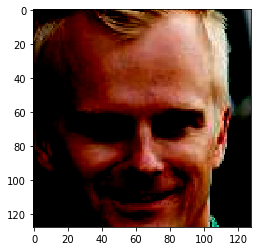

In [9]:
def load_image(img_path):
    img = tf.io.read_file(img_path) 
    img = tf.image.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # img = tf.image.resize(img, [64, 64])
    img = tf.image.resize_with_crop_or_pad(img, 128, 128)
    # img = tf.image.central_crop(img, 0.5)
    img = img * 2 - 1
    return img

raw = load_image('D:/Data/Face/celeba/Male/positive/000013.jpg')

print(raw)

# croped = tf.image.resize_with_crop_or_pad(raw, 40, 40)
# print(croped)

plt.imshow(raw)
plt.show()

In [2]:
tf.keras.backend.clear_session() 

def make_generator_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.Input(shape=(100, )))

    model.add(layers.Dense(8 * 8 * 256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5),
                               strides=(1, 1),
                               padding='same',
                               use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 8, 8, 128)

    model.add(layers.Conv2DTranspose(64, (5, 5),
                               strides=(2, 2),
                               padding='same',
                               use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 16, 16, 64)

    model.add(layers.Conv2DTranspose(32, (5, 5),
                               strides=(2, 2),
                               padding='same',
                               use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 32, 32, 32)

    model.add(layers.Conv2DTranspose(3, (5, 5),
                               strides=(2, 2),
                               padding='same',
                               use_bias=False,
                               activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)


    return model


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(64, 64, 3)))

    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


tf.Tensor(
[[[0.5000515  0.49995333 0.4999749 ]
  [0.49991745 0.5005083  0.50038713]
  [0.4996792  0.49945414 0.49959448]
  ...
  [0.49917975 0.49952796 0.5002977 ]
  [0.4999819  0.50022465 0.4994988 ]
  [0.5001827  0.49963543 0.4999791 ]]

 [[0.499758   0.4996384  0.49979103]
  [0.50064677 0.5004723  0.49967   ]
  [0.49993268 0.49908116 0.49997172]
  ...
  [0.4987022  0.50079536 0.49953234]
  [0.50080675 0.50068486 0.5002738 ]
  [0.5008871  0.50057894 0.49985766]]

 [[0.4999339  0.5000191  0.49993405]
  [0.49989948 0.4990822  0.49942818]
  [0.4998803  0.5005425  0.4997492 ]
  ...
  [0.49891248 0.5008072  0.5009789 ]
  [0.4987893  0.5005183  0.4999073 ]
  [0.49951676 0.49881735 0.49916604]]

 ...

 [[0.49958846 0.4990822  0.4992899 ]
  [0.50231844 0.5015454  0.4997478 ]
  [0.5002319  0.49971366 0.5005244 ]
  ...
  [0.49841055 0.5027593  0.50388813]
  [0.50367737 0.4995034  0.4990655 ]
  [0.49926522 0.50499433 0.49923098]]

 [[0.50023335 0.49974003 0.49899668]
  [0.49937916 0.49875605 0

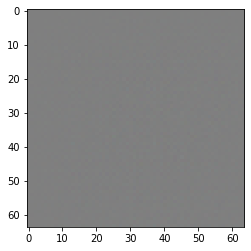

In [6]:
noise = tf.random.normal([1, 100])
generator = make_generator_model()
predict = generator(noise, training=False)
predict = (predict + 1) / 2
print(predict[0])
plt.imshow(predict[0])
plt.show()

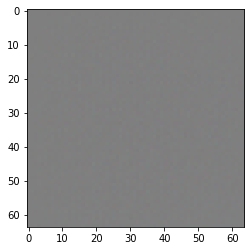

In [5]:
plt.imshow((predict[0] + 1) / 2)
plt.show()